<a href="https://colab.research.google.com/github/avbarbaros/gradient-descent/blob/main/gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# -------------------------------------------------------------------------
# GRADIENT DESCENT WITH BACKTRACKING LINE SEARCH
# -------------------------------------------------------------------------

BACKTRACKING LINE SEARCH:
- Automatically adapts step size
- Robust to different initial points
- Guarantees sufficient decrease (Armijo condition)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import pandas as pd

# =============================================================================
# 1. GRADIENT DESCENT IMPLEMENTATION
# =============================================================================

def gradient_descent_backtracking(f, grad_f, x0, max_iter=1000, tol=1e-6,
                                   alpha=0.3, beta=0.8, initial_step=1.0):
    """
    Gradient descent with backtracking line search (Armijo rule).

    Parameters:
    -----------
    f : callable
        Objective function
    grad_f : callable
        Gradient of objective function
    x0 : array-like
        Initial point
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance
    alpha : float
        Armijo condition parameter (0 < alpha < 0.5)
    beta : float
        Step size reduction factor (0 < beta < 1)
    initial_step : float
        Initial step size for backtracking

    Returns:
    --------
    x_opt : array
        Optimal point found
    history : dict
        Dictionary containing optimization history
    """
    x = np.array(x0, dtype=float)
    history = {
        'x': [x.copy()],
        'f': [f(x)],
        'grad_norm': [np.linalg.norm(grad_f(x))],
        'step_size': []
    }

    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        # Check convergence
        if grad_norm < tol:
            print(f"Converged in {k} iterations (gradient norm < {tol})")
            break

        # Backtracking line search
        t = initial_step
        fx = f(x)
        descent_dir = -grad

        # Armijo condition: f(x + t*d) <= f(x) + alpha * t * grad^T * d
        while f(x + t * descent_dir) > fx + alpha * t * np.dot(grad, descent_dir):
            t *= beta
            if t < 1e-16:  # Prevent step size from becoming too small
                print(f"Step size became too small at iteration {k}")
                break

        # Update
        x = x + t * descent_dir
        history['step_size'].append(t)
        history['x'].append(x.copy())
        history['f'].append(f(x))
        history['grad_norm'].append(grad_norm)

    else:
        print(f"Reached maximum iterations ({max_iter})")

    return x, history


def gradient_descent_fixed(f, grad_f, x0, step_size=0.01, max_iter=1000, tol=1e-6):
    """
    Gradient descent with fixed step size.

    Parameters:
    -----------
    f : callable
        Objective function
    grad_f : callable
        Gradient of objective function
    x0 : array-like
        Initial point
    step_size : float
        Fixed step size
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance

    Returns:
    --------
    x_opt : array
        Optimal point found
    history : dict
        Dictionary containing optimization history
    """
    x = np.array(x0, dtype=float)
    history = {
        'x': [x.copy()],
        'f': [f(x)],
        'grad_norm': [np.linalg.norm(grad_f(x))],
        'step_size': []
    }

    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm < tol:
            print(f"Converged in {k} iterations (gradient norm < {tol})")
            break

        x = x - step_size * grad
        history['step_size'].append(step_size)
        history['x'].append(x.copy())
        history['f'].append(f(x))
        history['grad_norm'].append(grad_norm)

    else:
        print(f"Reached maximum iterations ({max_iter})")

    return x, history


# =============================================================================
# 2. TEST FUNCTIONS: ROSENBROCK AND HIMMELBLAU
# =============================================================================

class Rosenbrock:
    """Rosenbrock function (Banana function)"""

    def __init__(self, a=1, b=100):
        self.a = a
        self.b = b
        self.optimum = np.array([a, a**2])
        self.f_opt = 0.0

    def __call__(self, x):
        """f(x,y) = (a-x)^2 + b(y-x^2)^2"""
        return (self.a - x[0])**2 + self.b * (x[1] - x[0]**2)**2

    def gradient(self, x):
        """Gradient of Rosenbrock function"""
        dx = -2*(self.a - x[0]) - 4*self.b*x[0]*(x[1] - x[0]**2)
        dy = 2*self.b*(x[1] - x[0]**2)
        return np.array([dx, dy])


class Himmelblau:
    """Himmelblau's function"""

    def __init__(self):
        # Himmelblau has 4 local minima
        self.optima = [
            np.array([3.0, 2.0]),
            np.array([-2.805118, 3.131312]),
            np.array([-3.779310, -3.283186]),
            np.array([3.584428, -1.848126])
        ]
        self.f_opt = 0.0

    def __call__(self, x):
        """f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2"""
        return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

    def gradient(self, x):
        """Gradient of Himmelblau function"""
        dx = 4*x[0]*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)
        dy = 2*(x[0]**2 + x[1] - 11) + 4*x[1]*(x[0] + x[1]**2 - 7)
        return np.array([dx, dy])


# =============================================================================
# 3. VISUALIZATION FUNCTIONS
# =============================================================================

def plot_function_contour(func, x_range, y_range, title="", levels=50):
    """Create contour plot of function"""
    x = np.linspace(x_range[0], x_range[1], 400)
    y = np.linspace(y_range[0], y_range[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.6)
    contourf = ax.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.3)
    plt.colorbar(contourf, ax=ax, label='Function value')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    return fig, ax, (X, Y, Z)


def plot_optimization_path(func, history, x_range, y_range, title=""):
    """Plot optimization path on function contour"""
    fig, ax, _ = plot_function_contour(func, x_range, y_range, title)

    # Extract path
    path = np.array(history['x'])

    # Plot path
    ax.plot(path[:, 0], path[:, 1], 'r.-', linewidth=2, markersize=8,
            label='Optimization path', alpha=0.7)
    ax.plot(path[0, 0], path[0, 1], 'go', markersize=15,
            label='Start', markeredgecolor='black', markeredgewidth=2)
    ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=20,
            label='End', markeredgecolor='black', markeredgewidth=2)

    ax.legend(loc='best')
    plt.tight_layout()

    return fig, ax


def plot_convergence(histories, labels, title="Convergence Analysis"):
    """Plot convergence metrics for multiple runs"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Function value
    ax = axes[0, 0]
    for history, label in zip(histories, labels):
        ax.semilogy(history['f'], label=label, linewidth=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Function value (log scale)')
    ax.set_title('Objective Function Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Gradient norm
    ax = axes[0, 1]
    for history, label in zip(histories, labels):
        ax.semilogy(history['grad_norm'], label=label, linewidth=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Gradient norm (log scale)')
    ax.set_title('Gradient Norm')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Step size (if available)
    ax = axes[1, 0]
    for history, label in zip(histories, labels):
        if history['step_size']:
            ax.plot(history['step_size'], label=label, linewidth=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Step size')
    ax.set_title('Step Size Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Distance to optimum (if optimum is known)
    ax = axes[1, 1]
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Distance to optimum')
    ax.set_title('Distance to Optimum')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, y=1.00)
    plt.tight_layout()

    return fig


def plot_3d_surface(func, x_range, y_range, history=None, title=""):
    """Create 3D surface plot with optional optimization path"""
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6,
                          edgecolor='none', antialiased=True)

    if history is not None:
        path = np.array(history['x'])
        path_z = np.array([func(p) for p in path])
        ax.plot(path[:, 0], path[:, 1], path_z, 'r.-', linewidth=2,
                markersize=6, label='Optimization path')
        ax.scatter(path[0, 0], path[0, 1], path_z[0], c='green',
                  s=100, marker='o', label='Start', edgecolors='black')
        ax.scatter(path[-1, 0], path[-1, 1], path_z[-1], c='red',
                  s=200, marker='*', label='End', edgecolors='black')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x,y)')
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    if history is not None:
        ax.legend()

    return fig, ax


# =============================================================================
# 4. EXPERIMENTAL SETUP AND ANALYSIS
# =============================================================================

def compare_initial_points(func, grad_func, initial_points, func_name="Function",
                          x_range=(-5, 5), y_range=(-5, 5)):
    """Study effect of different initial points"""
    print(f"\n{'='*70}")
    print(f"INITIAL POINT ANALYSIS FOR {func_name.upper()}")
    print(f"{'='*70}\n")

    histories = []
    labels = []

    for i, x0 in enumerate(initial_points):
        print(f"Initial point {i+1}: {x0}")
        x_opt, history = gradient_descent_backtracking(
            func, grad_func, x0, max_iter=1000, tol=1e-6
        )
        print(f"Final point: {x_opt}")
        print(f"Final value: {func(x_opt):.6e}")
        print(f"Iterations: {len(history['x']) - 1}\n")

        histories.append(history)
        labels.append(f"Start: ({x0[0]:.1f}, {x0[1]:.1f})")

    # Visualize all paths on same plot
    fig, ax, _ = plot_function_contour(func, x_range, y_range,
                                       f"{func_name} - Multiple Initial Points")

    colors = plt.cm.rainbow(np.linspace(0, 1, len(histories)))
    for history, label, color in zip(histories, labels, colors):
        path = np.array(history['x'])
        ax.plot(path[:, 0], path[:, 1], '.-', color=color, linewidth=2,
                markersize=6, label=label, alpha=0.7)
        ax.plot(path[0, 0], path[0, 1], 'o', color=color, markersize=12,
                markeredgecolor='black', markeredgewidth=2)
        ax.plot(path[-1, 0], path[-1, 1], '*', color=color, markersize=15,
                markeredgecolor='black', markeredgewidth=2)

    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

    # Convergence comparison
    plot_convergence(histories, labels,
                    f"{func_name} - Initial Point Comparison")
    plt.show()

    return histories


def compare_step_size_methods(func, grad_func, x0, func_name="Function",
                              x_range=(-5, 5), y_range=(-5, 5)):
    """Compare fixed step size vs adaptive (backtracking) methods"""
    print(f"\n{'='*70}")
    print(f"FIXED VS ADAPTIVE STEP SIZE COMPARISON FOR {func_name.upper()}")
    print(f"{'='*70}\n")

    # Backtracking line search
    print("Method: Backtracking Line Search")
    x_opt_bt, history_bt = gradient_descent_backtracking(
        func, grad_func, x0, max_iter=1000, tol=1e-6
    )
    print(f"Final point: {x_opt_bt}")
    print(f"Final value: {func(x_opt_bt):.6e}")
    print(f"Iterations: {len(history_bt['x']) - 1}\n")

    # Fixed step size (try multiple values)
    fixed_steps = [0.001, 0.01, 0.1]
    histories_fixed = []

    for step in fixed_steps:
        print(f"Method: Fixed Step Size (α = {step})")
        try:
            x_opt_fixed, history_fixed = gradient_descent_fixed(
                func, grad_func, x0, step_size=step, max_iter=1000, tol=1e-6
            )
            print(f"Final point: {x_opt_fixed}")
            print(f"Final value: {func(x_opt_fixed):.6e}")
            print(f"Iterations: {len(history_fixed['x']) - 1}\n")
            histories_fixed.append((history_fixed, step))
        except:
            print(f"Failed to converge with step size {step}\n")

    # Visualization
    fig, axes = plt.subplots(1, len(histories_fixed) + 1,
                            figsize=(6*(len(histories_fixed)+1), 5))

    # Backtracking
    ax = axes[0]
    x = np.linspace(x_range[0], x_range[1], 200)
    y = np.linspace(y_range[0], y_range[1], 200)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    ax.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.6)
    path = np.array(history_bt['x'])
    ax.plot(path[:, 0], path[:, 1], 'r.-', linewidth=2, markersize=6)
    ax.plot(path[0, 0], path[0, 1], 'go', markersize=12)
    ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=15)
    ax.set_title('Backtracking Line Search')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)

    # Fixed step sizes
    for idx, (history, step) in enumerate(histories_fixed):
        ax = axes[idx + 1]
        ax.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.6)
        path = np.array(history['x'])
        ax.plot(path[:, 0], path[:, 1], 'b.-', linewidth=2, markersize=6)
        ax.plot(path[0, 0], path[0, 1], 'go', markersize=12)
        ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=15)
        ax.set_title(f'Fixed α = {step}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True, alpha=0.3)

    plt.suptitle(f"{func_name} - Step Size Comparison", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Convergence comparison
    all_histories = [history_bt] + [h for h, _ in histories_fixed]
    all_labels = ['Backtracking'] + [f'Fixed α={s}' for _, s in histories_fixed]
    plot_convergence(all_histories, all_labels,
                    f"{func_name} - Step Size Method Comparison")
    plt.show()

    return history_bt, histories_fixed

# -------------------------------------------------------------------------
# EXPERIMENT 1: Rosenbrock Function - Single Run
# -------------------------------------------------------------------------
ROSENBROCK FUNCTION:
- Narrow curved valley makes optimization challenging
- Converges to global minimum (1, 1)
- Adaptive step size significantly outperforms fixed step



EXPERIMENT 1: ROSENBROCK FUNCTION - BASIC RUN

Initial point: [-1.5  2.5]
Reached maximum iterations (5000)
Optimal point found: [1.02033016 1.04109712]
Optimal value: 4.133704e-04
True optimum: [1 1]
Distance to true optimum: 4.585072e-02


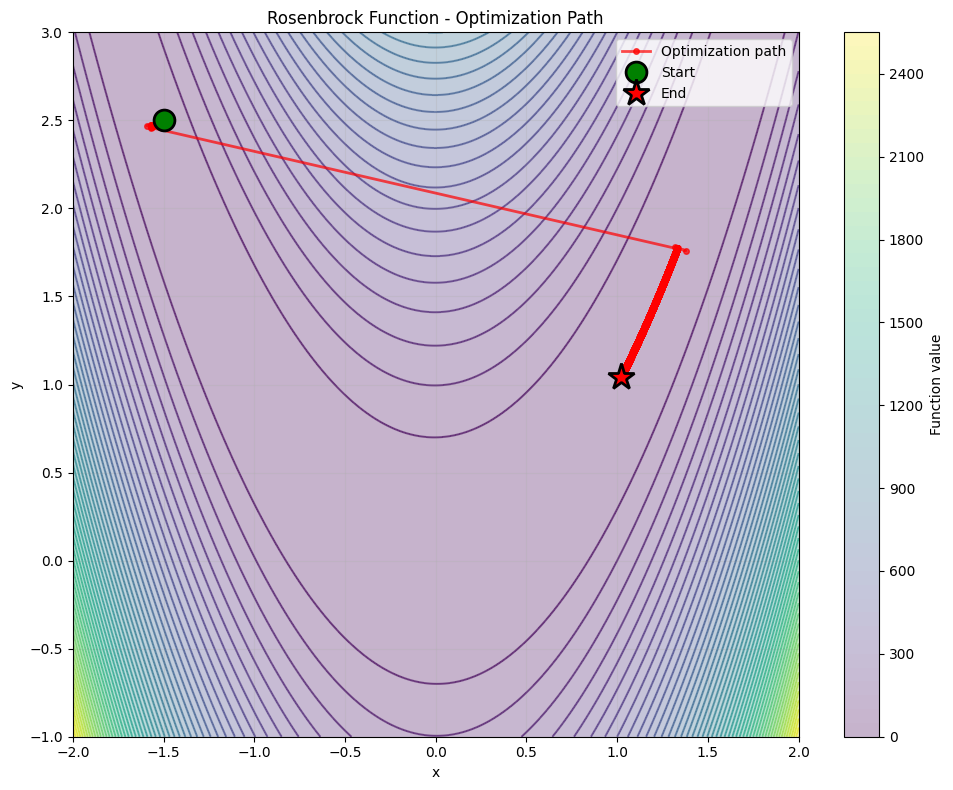

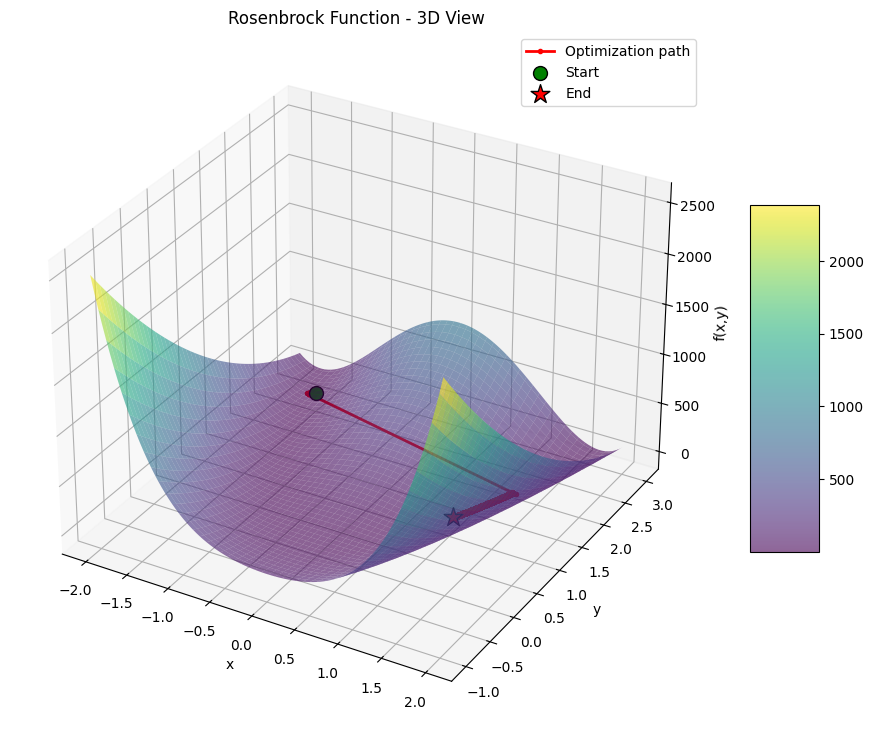

/tmp/ipython-input-1496025232.py:275: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


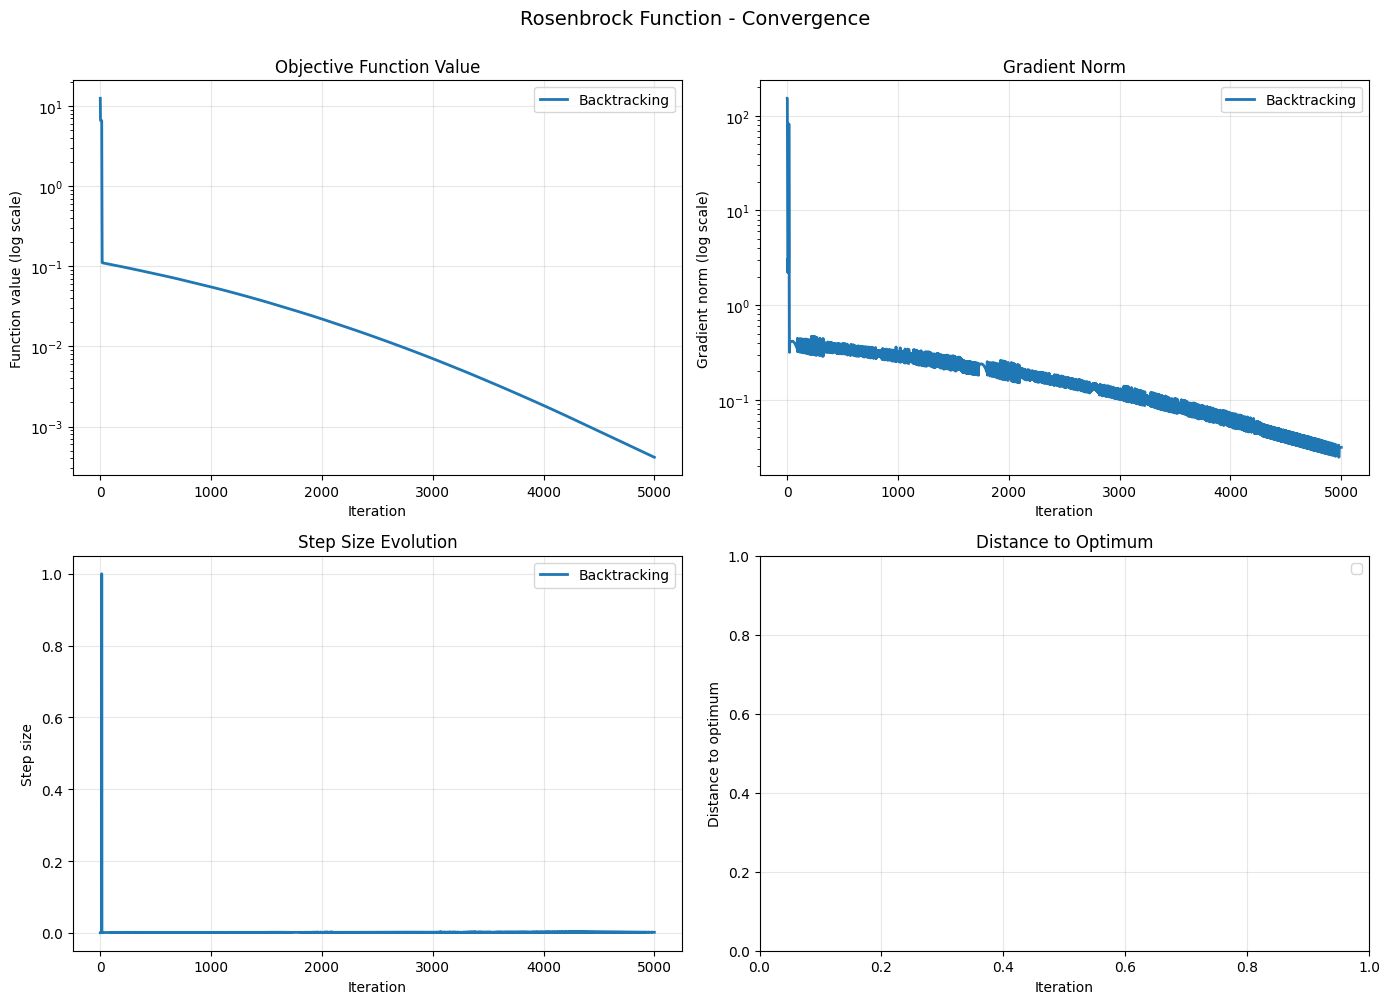

In [2]:

rosenbrock = Rosenbrock(a=1, b=100)
print("\n\n" + "="*70)
print("EXPERIMENT 1: ROSENBROCK FUNCTION - BASIC RUN")
print("="*70)

x0_rb = np.array([-1.5, 2.5])
print(f"\nInitial point: {x0_rb}")

x_opt, history = gradient_descent_backtracking(
    rosenbrock, rosenbrock.gradient, x0_rb, max_iter=5000, tol=1e-6
)

print(f"Optimal point found: {x_opt}")
print(f"Optimal value: {rosenbrock(x_opt):.6e}")
print(f"True optimum: {rosenbrock.optimum}")
print(f"Distance to true optimum: {np.linalg.norm(x_opt - rosenbrock.optimum):.6e}")

# Visualizations
plot_optimization_path(rosenbrock, history, (-2, 2), (-1, 3),
                      "Rosenbrock Function - Optimization Path")
plt.show()

plot_3d_surface(rosenbrock, (-2, 2), (-1, 3), history,
                "Rosenbrock Function - 3D View")
plt.show()

plot_convergence([history], ['Backtracking'],
                "Rosenbrock Function - Convergence")
plt.show()

# -------------------------------------------------------------------------
# EXPERIMENT 2: Himmelblau Function - Single Run
# -------------------------------------------------------------------------
HIMMELBLAU FUNCTION:
- Multiple local minima (4 in total)
- Final solution depends on initial point
- All minima have same function value (0)



EXPERIMENT 2: HIMMELBLAU FUNCTION - BASIC RUN

Initial point: [0. 0.]
Converged in 28 iterations (gradient norm < 1e-06)
Optimal point found: [2.99999998 2.00000001]
Optimal value: 7.698844e-15

Himmelblau has 4 local minima:
  Minimum 1: [3. 2.], distance: 1.936851e-08
  Minimum 2: [-2.805118  3.131312], distance: 5.914327e+00
  Minimum 3: [-3.77931  -3.283186], distance: 8.594830e+00
  Minimum 4: [ 3.584428 -1.848126], distance: 3.892253e+00


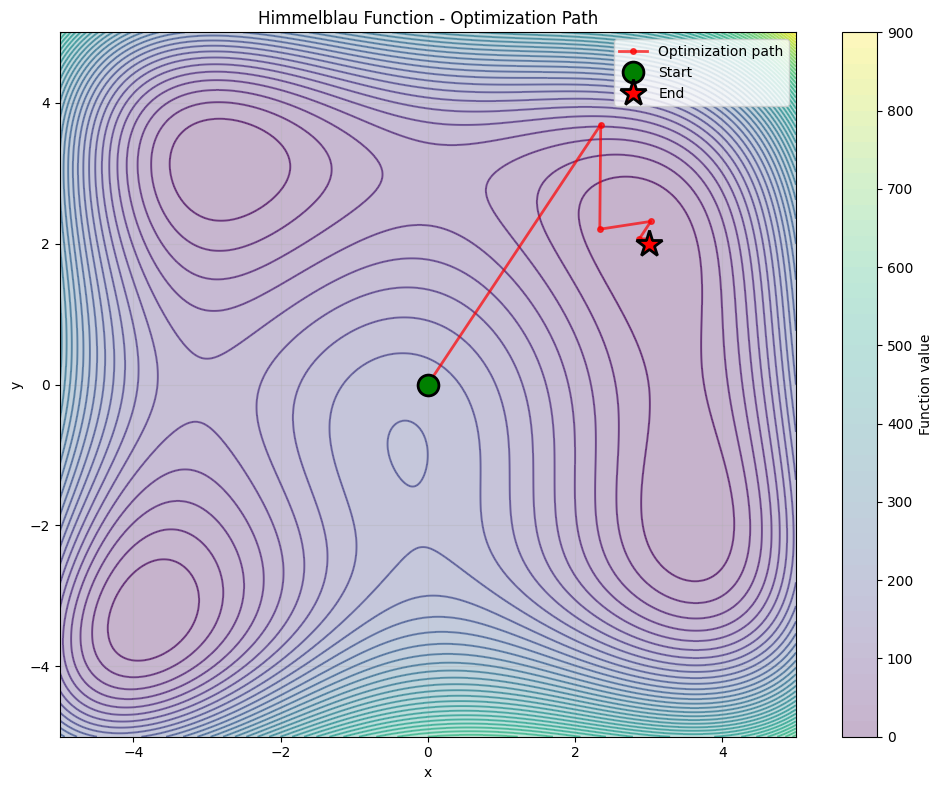

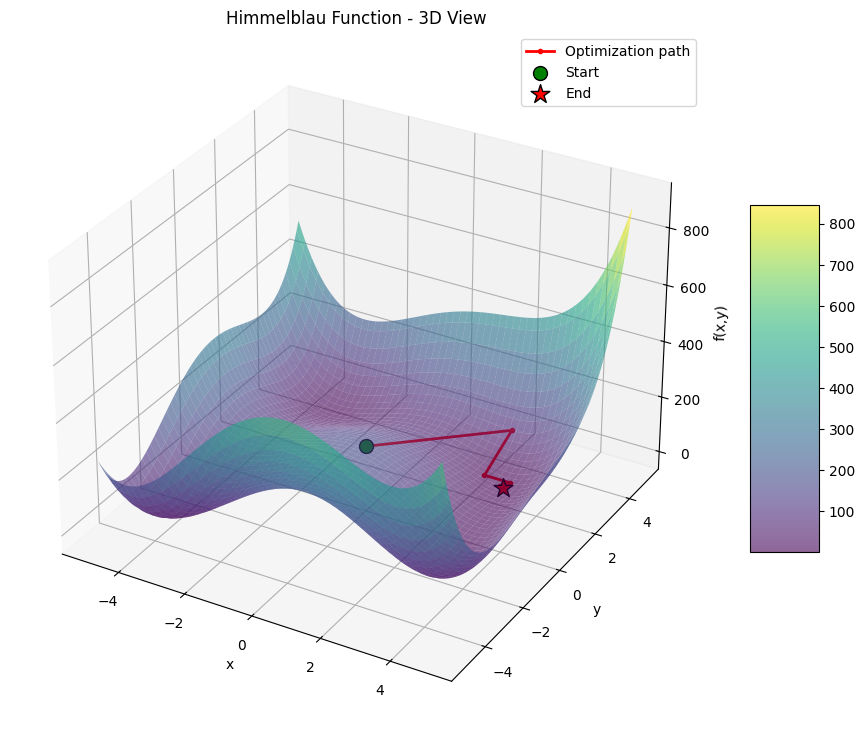

In [3]:
himmelblau = Himmelblau()
print("\n\n" + "="*70)
print("EXPERIMENT 2: HIMMELBLAU FUNCTION - BASIC RUN")
print("="*70)

x0_hb = np.array([0.0, 0.0])
print(f"\nInitial point: {x0_hb}")

x_opt, history = gradient_descent_backtracking(
    himmelblau, himmelblau.gradient, x0_hb, max_iter=1000, tol=1e-6
)

print(f"Optimal point found: {x_opt}")
print(f"Optimal value: {himmelblau(x_opt):.6e}")
print("\nHimmelblau has 4 local minima:")
for i, opt in enumerate(himmelblau.optima):
    dist = np.linalg.norm(x_opt - opt)
    print(f"  Minimum {i+1}: {opt}, distance: {dist:.6e}")

# Visualizations
plot_optimization_path(himmelblau, history, (-5, 5), (-5, 5),
                      "Himmelblau Function - Optimization Path")
plt.show()

plot_3d_surface(himmelblau, (-5, 5), (-5, 5), history,
                "Himmelblau Function - 3D View")
plt.show()

# -------------------------------------------------------------------------
# EXPERIMENT 3: Effect of Initial Point - Rosenbrock
# -------------------------------------------------------------------------
INITIAL POINT EFFECT:
- Critical for non-convex functions like Himmelblau
- Less critical for Rosenbrock (single minimum)
- Determines which local minimum is reached


INITIAL POINT ANALYSIS FOR ROSENBROCK

Initial point 1: [-1.5  2.5]
Reached maximum iterations (1000)
Final point: [1.23501207 1.52556521]
Final value: 5.524031e-02
Iterations: 1000

Initial point 2: [0. 0.]
Reached maximum iterations (1000)
Final point: [0.90386868 0.81680512]
Final value: 9.244239e-03
Iterations: 1000

Initial point 3: [1.5 1.5]
Reached maximum iterations (1000)
Final point: [1.16565252 1.35899267]
Final value: 2.744685e-02
Iterations: 1000

Initial point 4: [-0.5 -0.5]
Reached maximum iterations (1000)
Final point: [0.90340289 0.81542075]
Final value: 9.382271e-03
Iterations: 1000

Initial point 5: [2. 4.]
Reached maximum iterations (1000)
Final point: [1.92626665 3.71193937]
Final value: 8.581762e-01
Iterations: 1000



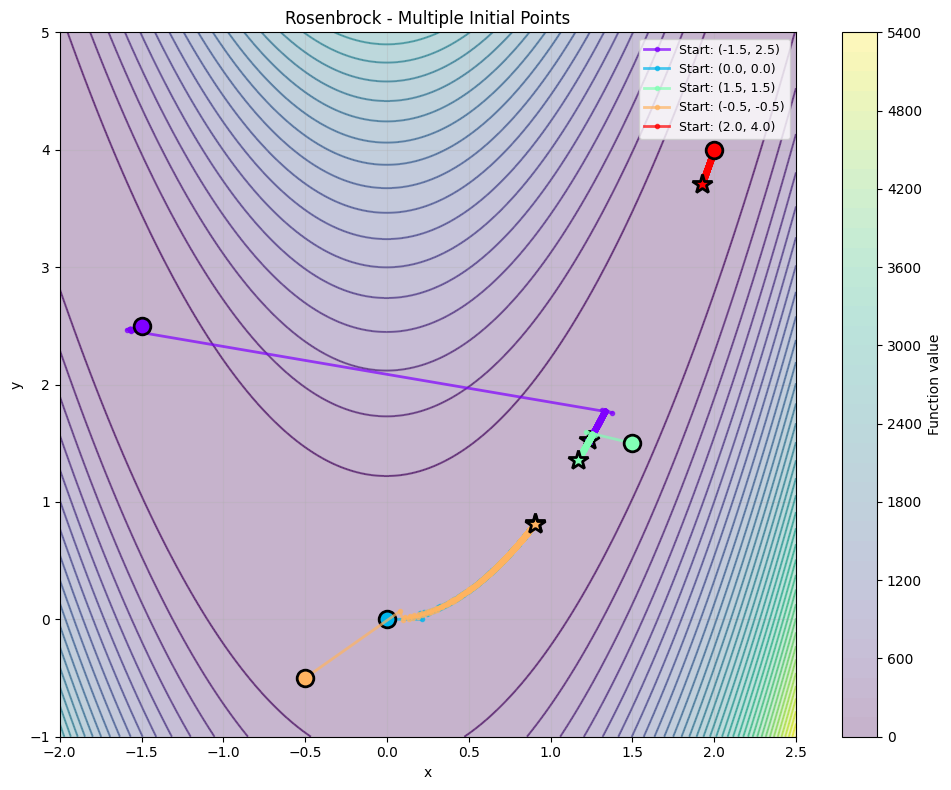

/tmp/ipython-input-1496025232.py:275: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


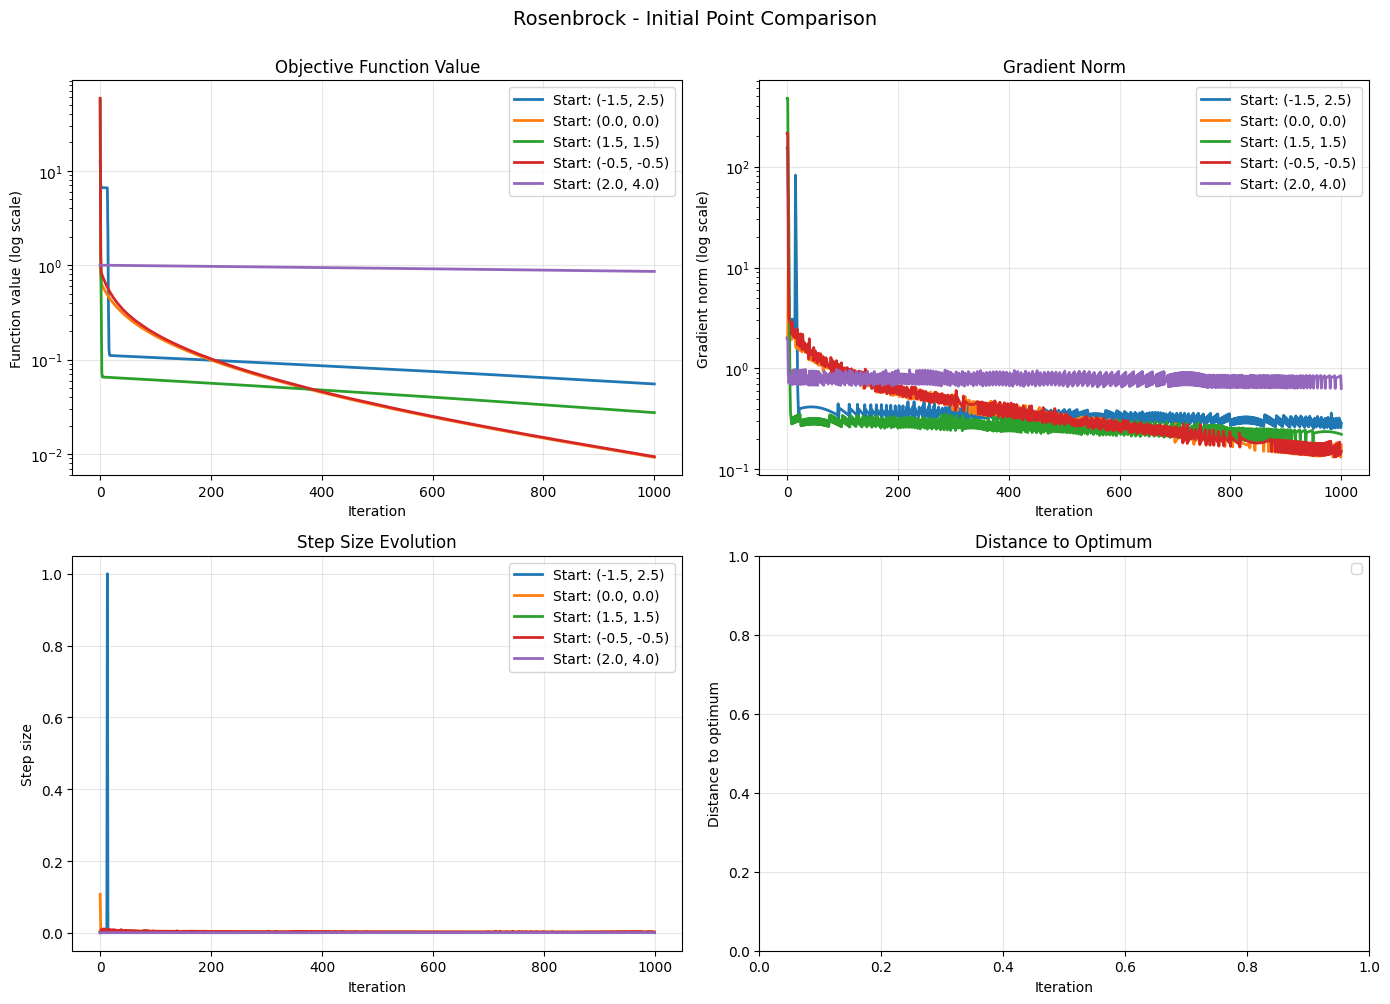

In [4]:
initial_points_rb = [
    np.array([-1.5, 2.5]),
    np.array([0.0, 0.0]),
    np.array([1.5, 1.5]),
    np.array([-0.5, -0.5]),
    np.array([2.0, 4.0])
]

histories_rb = compare_initial_points(
    rosenbrock, rosenbrock.gradient, initial_points_rb,
    "Rosenbrock", (-2, 2.5), (-1, 5)
)

# -------------------------------------------------------------------------
# EXPERIMENT 4: Effect of Initial Point - Himmelblau
# -------------------------------------------------------------------------
INITIAL POINT EFFECT:
- Critical for non-convex functions like Himmelblau
- Less critical for Rosenbrock (single minimum)
- Determines which local minimum is reached


INITIAL POINT ANALYSIS FOR HIMMELBLAU

Initial point 1: [0. 0.]
Converged in 28 iterations (gradient norm < 1e-06)
Final point: [2.99999998 2.00000001]
Final value: 7.698844e-15
Iterations: 28

Initial point 2: [3. 2.]
Converged in 0 iterations (gradient norm < 1e-06)
Final point: [3. 2.]
Final value: 0.000000e+00
Iterations: 0

Initial point 3: [-3.  3.]
Converged in 10 iterations (gradient norm < 1e-06)
Final point: [-2.80511809  3.13131251]
Final value: 4.634620e-15
Iterations: 10

Initial point 4: [-3. -3.]
Converged in 16 iterations (gradient norm < 1e-06)
Final point: [-3.77931025 -3.28318599]
Final value: 8.900719e-16
Iterations: 16

Initial point 5: [ 3.5 -2. ]
Converged in 29 iterations (gradient norm < 1e-06)
Final point: [ 3.58442835 -1.84812654]
Final value: 2.678438e-15
Iterations: 29



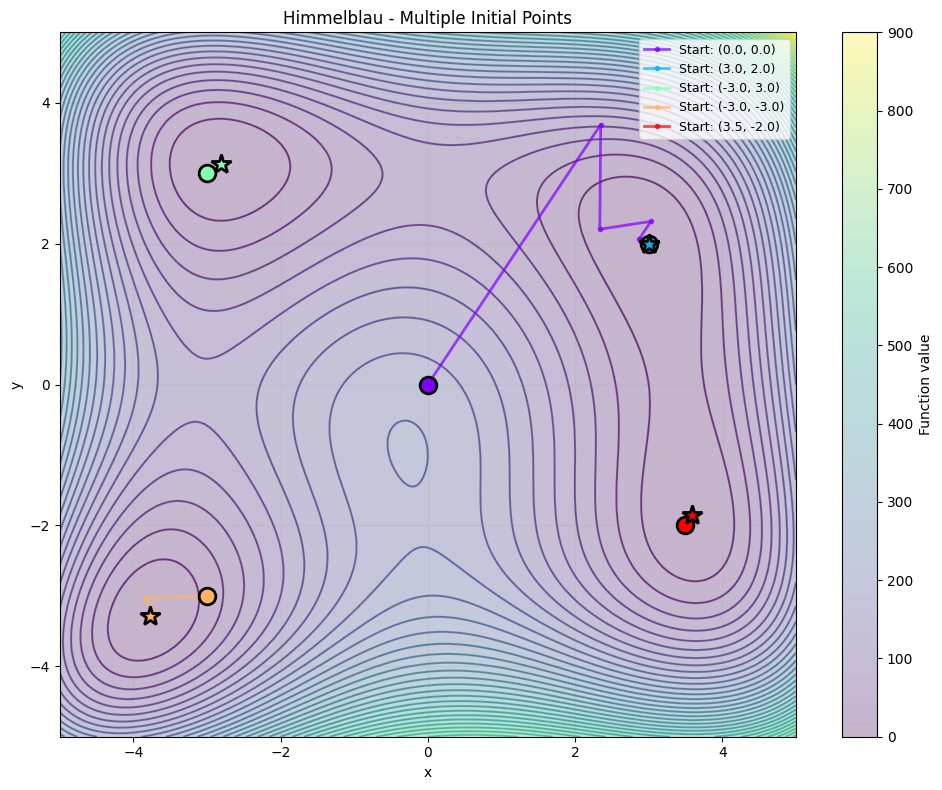

/tmp/ipython-input-1496025232.py:275: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


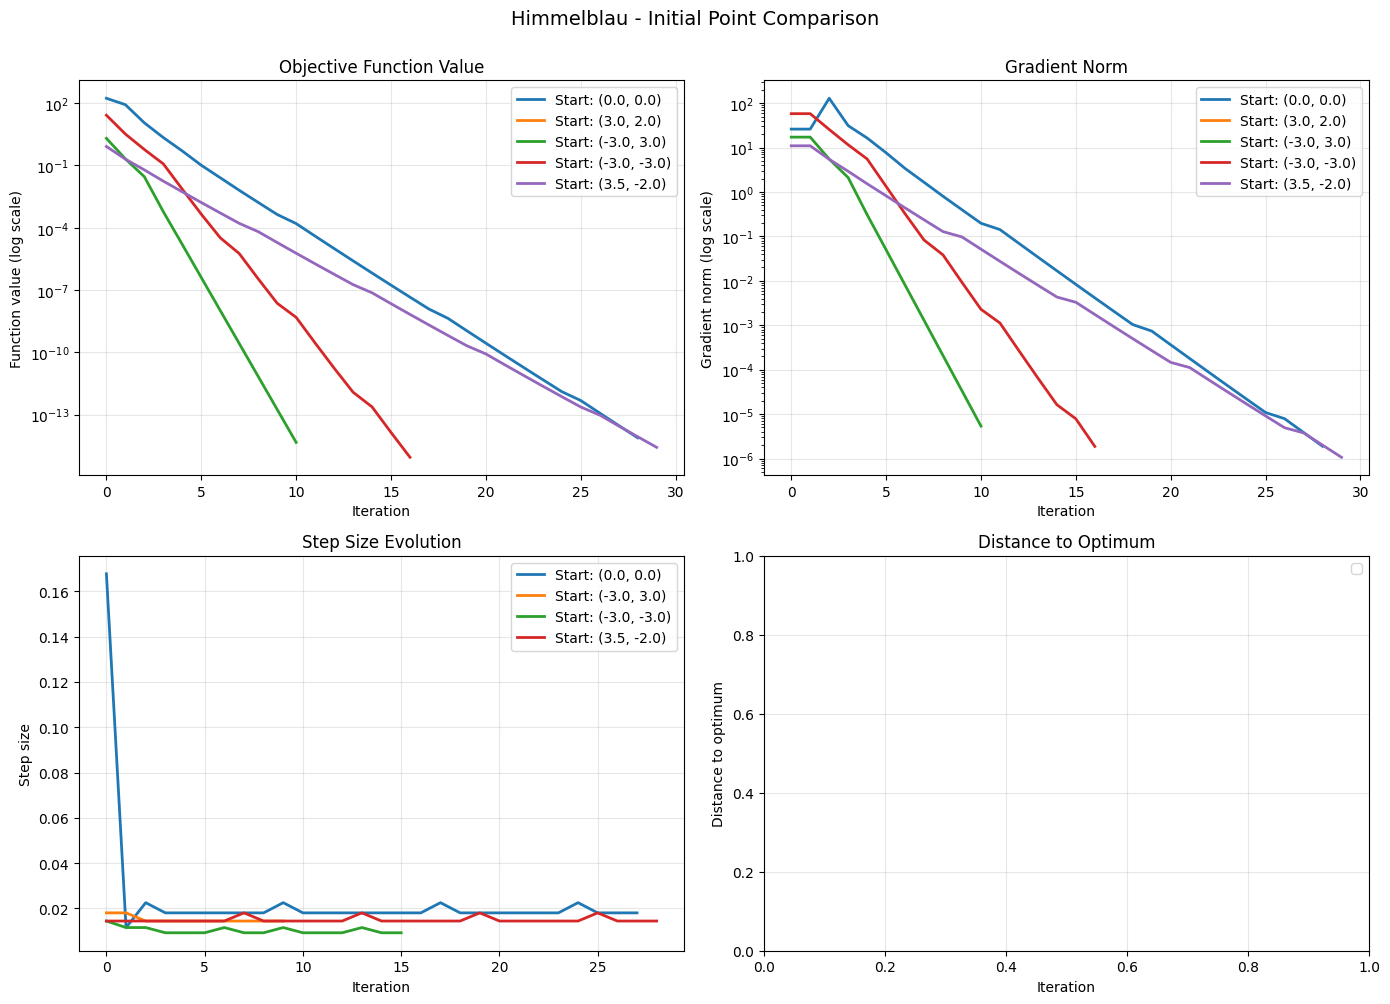

In [5]:
initial_points_hb = [
    np.array([0.0, 0.0]),
    np.array([3.0, 2.0]),
    np.array([-3.0, 3.0]),
    np.array([-3.0, -3.0]),
    np.array([3.5, -2.0])
]

histories_hb = compare_initial_points(
    himmelblau, himmelblau.gradient, initial_points_hb,
    "Himmelblau", (-5, 5), (-5, 5)
)

# -------------------------------------------------------------------------
# EXPERIMENT 5: Fixed vs Adaptive Step Size - Rosenbrock
# -------------------------------------------------------------------------
FIXED VS ADAPTIVE STEP SIZE:
- Fixed step size requires careful tuning
- Too large: divergence or oscillation
- Too small: very slow convergence
- Backtracking is more robust and efficient


FIXED VS ADAPTIVE STEP SIZE COMPARISON FOR ROSENBROCK

Method: Backtracking Line Search
Reached maximum iterations (1000)
Final point: [1.23501207 1.52556521]
Final value: 5.524031e-02
Iterations: 1000

Method: Fixed Step Size (α = 0.001)
Reached maximum iterations (1000)
Final point: [-0.81205782  0.66752665]
Final value: 3.290096e+00
Iterations: 1000

Method: Fixed Step Size (α = 0.01)
Reached maximum iterations (1000)
Final point: [nan nan]
Final value: nan
Iterations: 1000

Method: Fixed Step Size (α = 0.1)
Reached maximum iterations (1000)
Final point: [nan nan]
Final value: nan
Iterations: 1000



/tmp/ipython-input-1496025232.py:154: RuntimeWarning: overflow encountered in scalar power
  return (self.a - x[0])**2 + self.b * (x[1] - x[0]**2)**2
/tmp/ipython-input-1496025232.py:158: RuntimeWarning: overflow encountered in scalar power
  dx = -2*(self.a - x[0]) - 4*self.b*x[0]*(x[1] - x[0]**2)
/tmp/ipython-input-1496025232.py:159: RuntimeWarning: overflow encountered in scalar power
  dy = 2*self.b*(x[1] - x[0]**2)
/tmp/ipython-input-1496025232.py:154: RuntimeWarning: invalid value encountered in scalar subtract
  return (self.a - x[0])**2 + self.b * (x[1] - x[0]**2)**2
/tmp/ipython-input-1496025232.py:158: RuntimeWarning: invalid value encountered in scalar subtract
  dx = -2*(self.a - x[0]) - 4*self.b*x[0]*(x[1] - x[0]**2)
/tmp/ipython-input-1496025232.py:159: RuntimeWarning: invalid value encountered in scalar subtract
  dy = 2*self.b*(x[1] - x[0]**2)


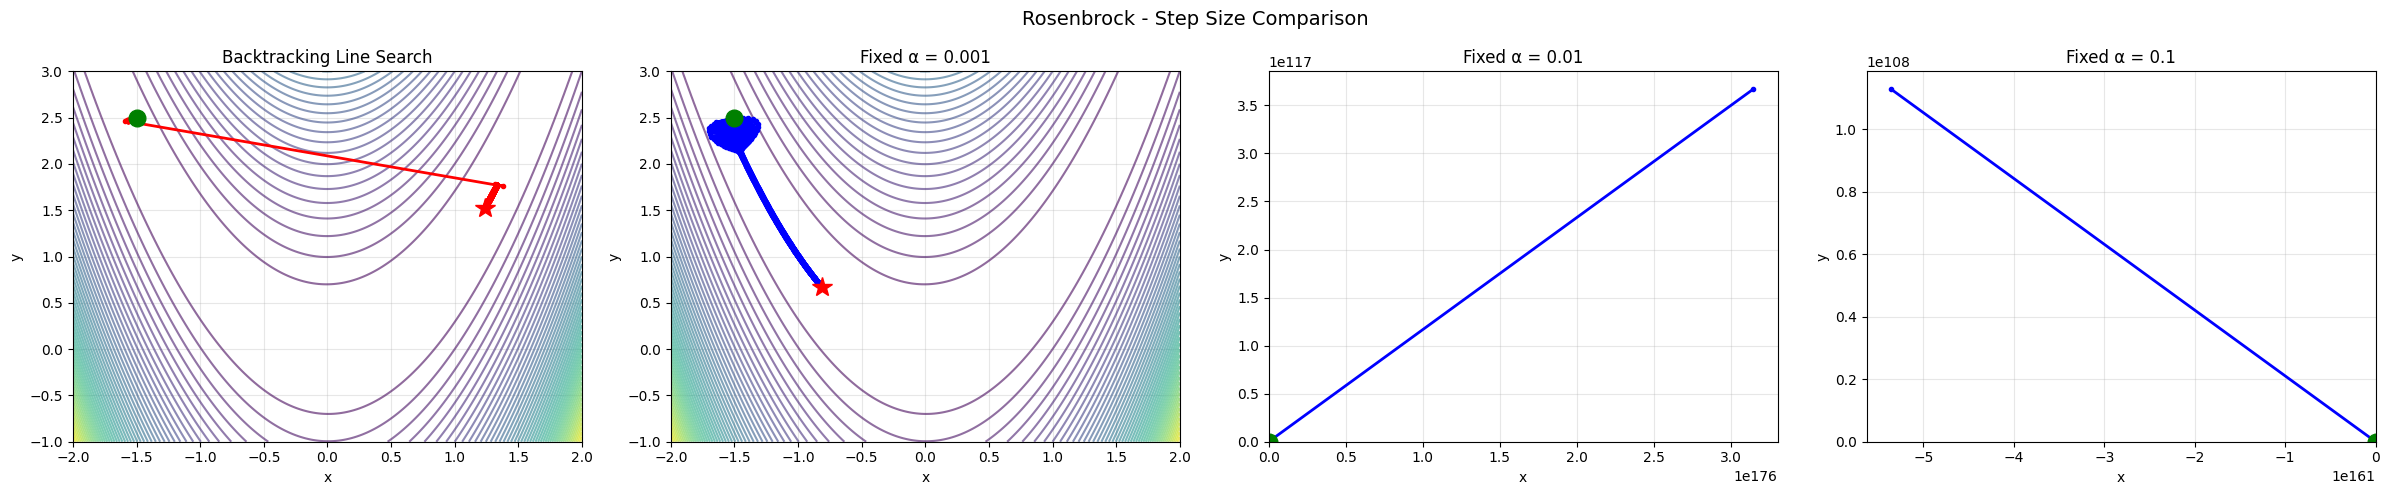

/tmp/ipython-input-1496025232.py:275: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


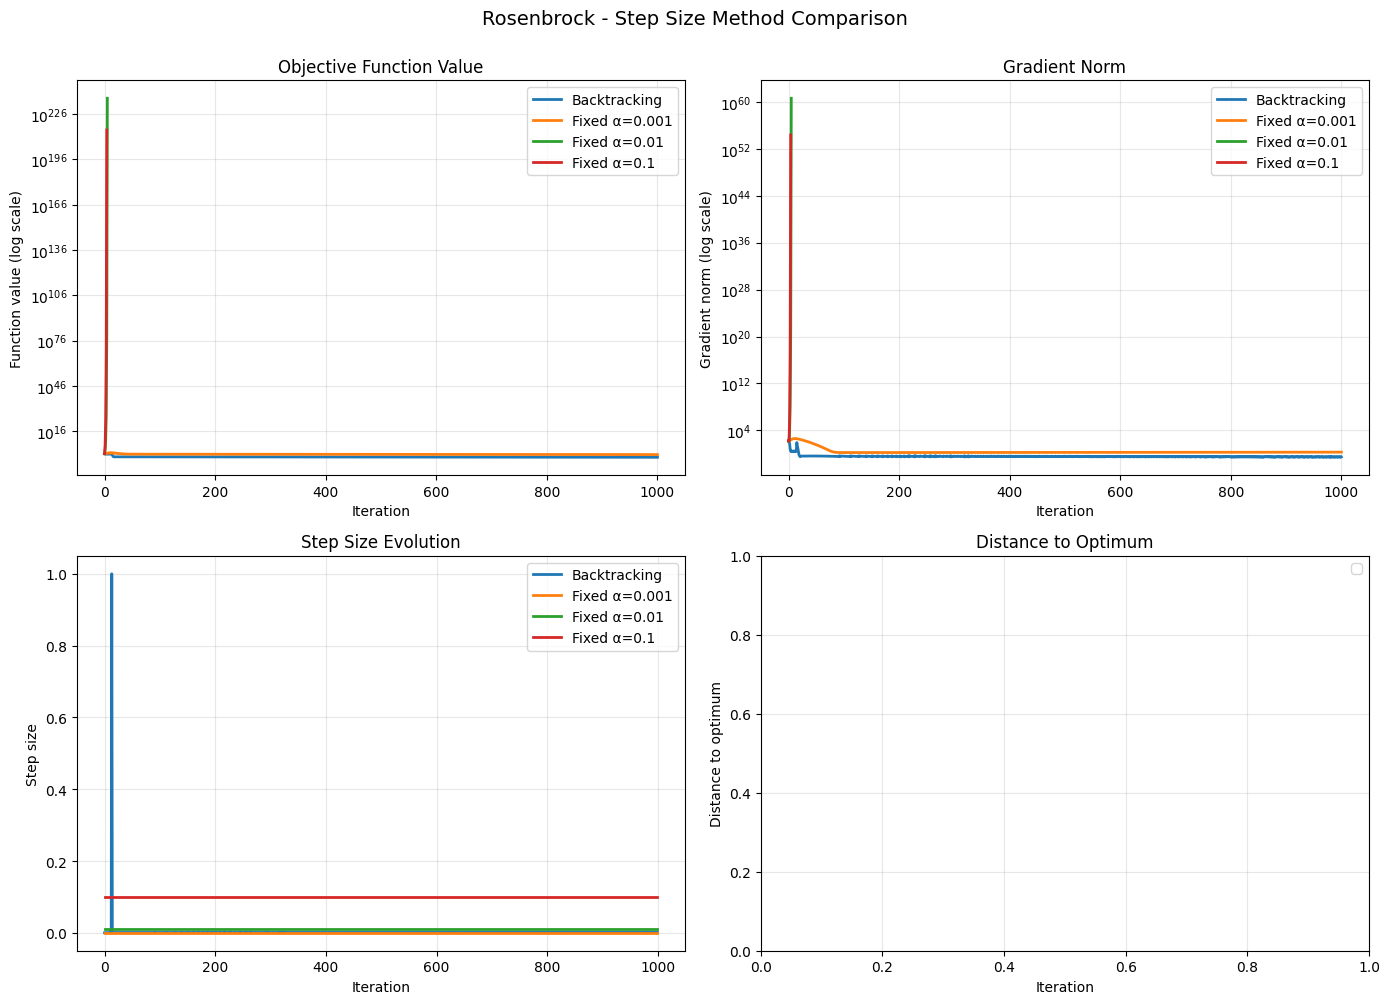

In [6]:
history_bt_rb, histories_fixed_rb = compare_step_size_methods(
    rosenbrock, rosenbrock.gradient, np.array([-1.5, 2.5]),
    "Rosenbrock", (-2, 2), (-1, 3)
)

# -------------------------------------------------------------------------
# EXPERIMENT 6: Fixed vs Adaptive Step Size - Himmelblau
# -------------------------------------------------------------------------
FIXED VS ADAPTIVE STEP SIZE:
- Fixed step size requires careful tuning
- Too large: divergence or oscillation
- Too small: very slow convergence
- Backtracking is more robust and efficient


FIXED VS ADAPTIVE STEP SIZE COMPARISON FOR HIMMELBLAU

Method: Backtracking Line Search
Converged in 28 iterations (gradient norm < 1e-06)
Final point: [2.99999998 2.00000001]
Final value: 7.698844e-15
Iterations: 28

Method: Fixed Step Size (α = 0.001)
Converged in 672 iterations (gradient norm < 1e-06)
Final point: [2.99999999 2.00000004]
Final value: 1.910505e-14
Iterations: 672

Method: Fixed Step Size (α = 0.01)
Converged in 62 iterations (gradient norm < 1e-06)
Final point: [2.99999999 2.00000003]
Final value: 1.447549e-14
Iterations: 62

Method: Fixed Step Size (α = 0.1)
Reached maximum iterations (1000)
Final point: [nan nan]
Final value: nan
Iterations: 1000



/tmp/ipython-input-1496025232.py:178: RuntimeWarning: overflow encountered in scalar power
  return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2
/tmp/ipython-input-1496025232.py:182: RuntimeWarning: overflow encountered in scalar multiply
  dx = 4*x[0]*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)
/tmp/ipython-input-1496025232.py:182: RuntimeWarning: overflow encountered in scalar power
  dx = 4*x[0]*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)
/tmp/ipython-input-1496025232.py:183: RuntimeWarning: overflow encountered in scalar power
  dy = 2*(x[0]**2 + x[1] - 11) + 4*x[1]*(x[0] + x[1]**2 - 7)
/tmp/ipython-input-1496025232.py:127: RuntimeWarning: invalid value encountered in subtract
  x = x - step_size * grad


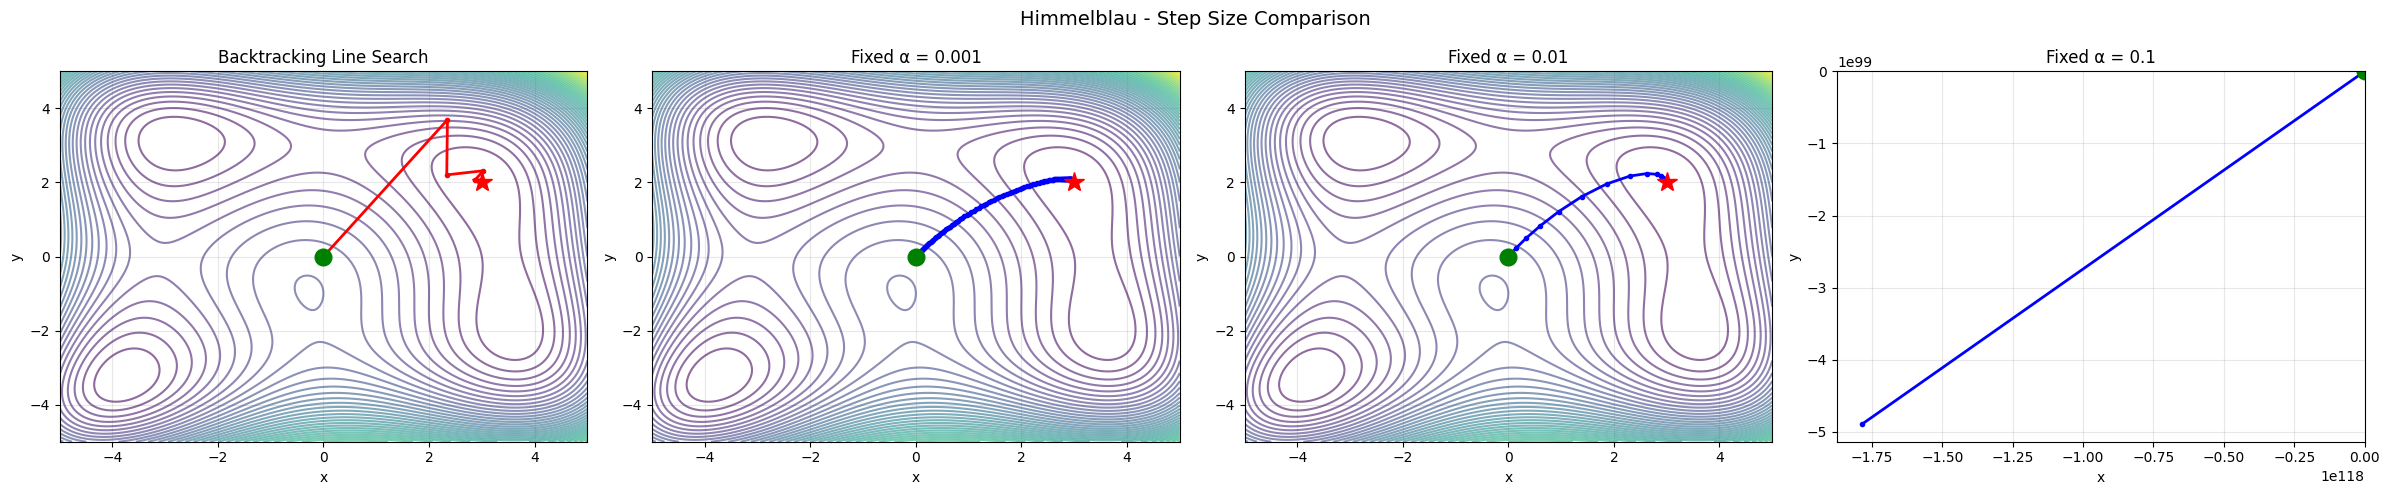

/tmp/ipython-input-1496025232.py:275: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


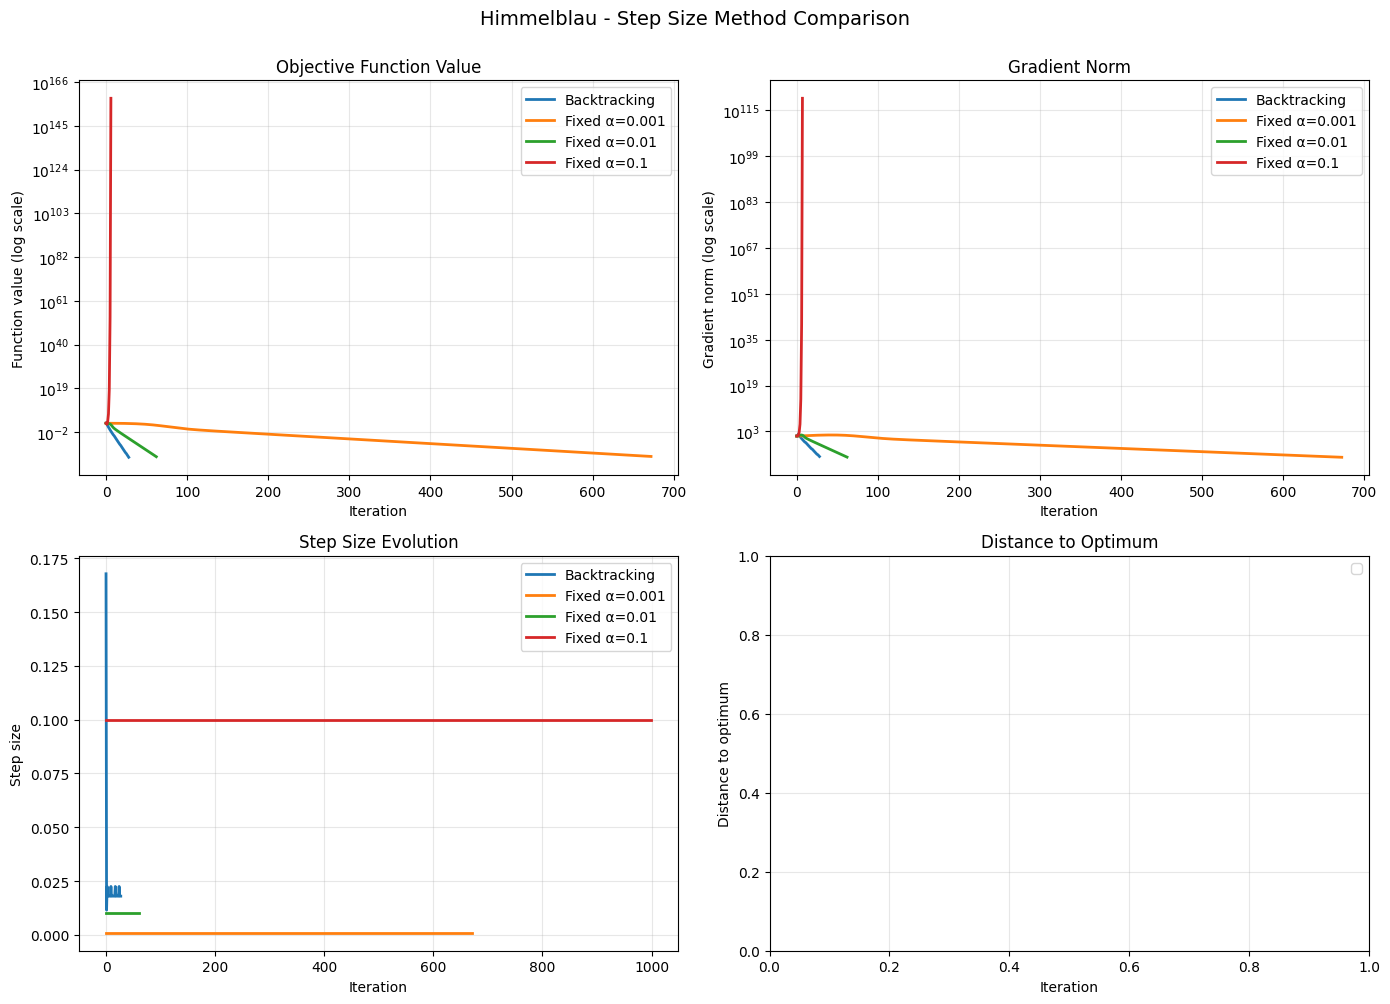

In [7]:
history_bt_hb, histories_fixed_hb = compare_step_size_methods(
    himmelblau, himmelblau.gradient, np.array([0.0, 0.0]),
    "Himmelblau", (-5, 5), (-5, 5)
)